<a href="https://colab.research.google.com/github/Manasi1/cmpe256/blob/main/GoodreadsReviewModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Evaluation Metric for Training model for Goodreads Reviews Data**

#### **Importing Surprise library for Collabertive filtering algorithms, Pandas**
#### **for loading dataset, and matplotlib library for visualizations**. 

In [ ]:
# Credits-Prof Eirinaki, Rashmi Sharma and Aditya Patel
# conda install -c conda-forge scikit-surprise
!pip install scikit-surprise
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import numpy as np
import os, io
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, SlopeOne, NMF
from surprise import SVDpp
from surprise import SVD
from surprise import accuracy

from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 11.8MB 3.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670946 sha256=312105f1ff33c2b5dc77ca5e0c8fe2494de4b74b31ad77ca4be13e0d70bfb050
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
# mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get the dataframe from CSV named goodread_reviews_1.csv in Google Drive

# Go to folder containing CSV
%cd "/content/drive/My Drive/data/ce256/project"
# load first 4 million reviews
goodreads_df = pd.read_csv("goodreads_reviews_1.csv")

# Check the CSV in Google Drive has the correct data
goodreads_df.head()

/content/drive/.shortcut-targets-by-id/1HAaJ2jKojgPKa8wfJoWiFU_cYq8hnytg/project


,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0


## Understanding Metadata of the dataset

In [ ]:
goodreads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000001 entries, 0 to 4000000
Data columns (total 11 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   book_id       int64 
 2   review_id     object
 3   rating        int64 
 4   review_text   object
 5   date_added    object
 6   date_updated  object
 7   read_at       object
 8   started_at    object
 9   n_votes       int64 
 10  n_comments    int64 
dtypes: int64(4), object(7)
memory usage: 335.7+ MB


In [ ]:
goodreads_df.describe()

,book_id,rating,n_votes,n_comments
count,4.000001e+06,4.000001e+06,4.000001e+06,4.000001e+06
mean,1.290124e+07,3.768724e+00,1.192645e+00,3.384324e-01
std,1.025331e+07,1.241666e+00,8.657892e+00,2.968977e+00
min,1.000000e+00,0.000000e+00,-3.000000e+00,-1.000000e+00
25%,1.885616e+06,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.301010e+07,4.000000e+00,0.000000e+00,0.000000e+00
75%,2.082104e+07,5.000000e+00,1.000000e+00,0.000000e+00
max,3.649449e+07,5.000000e+00,2.419000e+03,1.532000e+03


## Calculate total count of each rating

In [ ]:
total_count_rating = goodreads_df.groupby('rating')['rating'].agg(['count'])
total_count_rating

,count
rating,
0,130331
1,114107
2,285595
3,808260
4,1343716
5,1317992


## Unique book ids, user ids and total rating count

In [ ]:
book_count = goodreads_df["book_id"].nunique()
user_count = goodreads_df['user_id'].nunique()
rating_count = goodreads_df["rating"].count()

print('Unique Book Ids : ',book_count)
print('Unique User Ids : ',user_count)
print('Total rating count : ',user_count)

Unique Book Ids :  963125
Unique User Ids :  80920
Total rating count :  80920


# **Visualize the rating count**

In [ ]:
rts_gp = goodreads_df.groupby(by=['rating']).agg({'user_id': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']

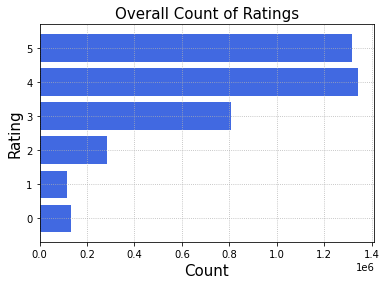

In [ ]:
plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

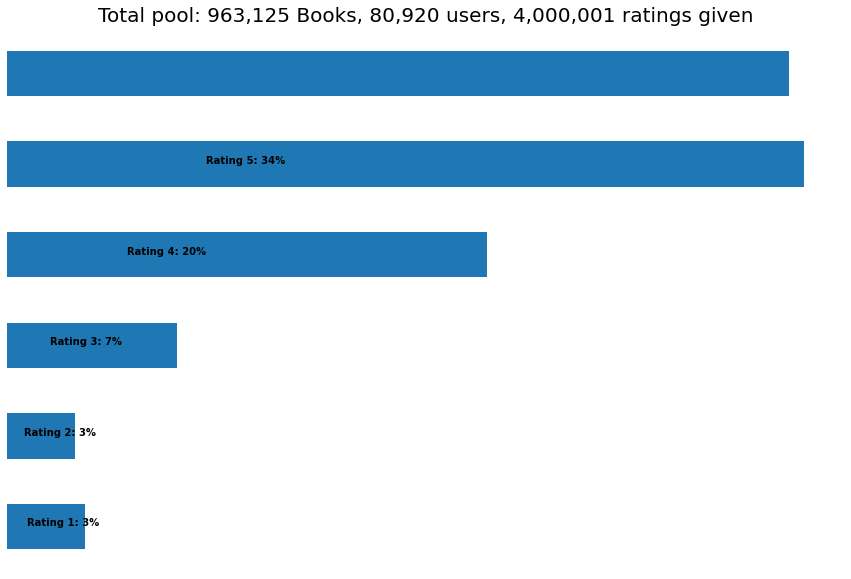

In [ ]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Books, {:,} users, {:,} ratings given'.format(book_count, user_count, rating_count), fontsize=20)
plt.axis('off')
          
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'black', weight = 'bold')

# **Check for Null values in User id, Book Id, and Review Id**

In [ ]:
goodreads_df.isnull().sum()

user_id               0
book_id               0
review_id             0
rating                0
review_text        1770
date_added            0
date_updated          0
read_at          710737
started_at      1790967
n_votes               0
n_comments            0
dtype: int64

# **Data Slicing**
To deal with huge dataset we need to trim the dataset for training the model. This will also improve the quality of our dataset.
Delete rows that contains books with less reviews.
Delete rows that contains users who give too reviews

In [ ]:
f = ['count','mean']

df_book_summary = goodreads_df.groupby('book_id')['rating'].agg(f)
book_benchmark = round(df_book_summary['count'].quantile(0.8),0)
drop_book_list = df_book_summary[df_book_summary['count'] < book_benchmark].index

print('Book minimum times of review: {}'.format(book_benchmark))

df_user_summary = goodreads_df.groupby('user_id')['rating'].agg(f)
user_benchmark = round(df_user_summary['count'].quantile(0.8),0)
drop_user_list = df_user_summary[df_user_summary['count'] < user_benchmark].index

print('User minimum times of review: {}'.format(user_benchmark))

Book minimum times of review: 3.0
User minimum times of review: 53.0


# **Trim Data**

In [ ]:
print('Original Shape: {}'.format(goodreads_df.shape))
goodreads_df = goodreads_df[~goodreads_df['book_id'].isin(drop_book_list)]
goodreads_df = goodreads_df[~goodreads_df['user_id'].isin(drop_user_list)]
print('After Trim Shape: {}'.format(goodreads_df.shape))
print('-Data Examples-')
print(goodreads_df.iloc[::20000, :])

Original Shape: (4000001, 11)
After Trim Shape: (2482671, 11)
-Data Examples-
                                  user_id   book_id  ... n_votes  n_comments
0        8842281e1d1347389f2ab93d60773d4d  24375664  ...      16           0
31697    037c382333b7084ccee4cdec7401de90     24178  ...       0           1
63419    61ab7baff4576c60ff7348ae12f7a331    234225  ...       0           0
93997    d76bb2c5bcebe4bedc35d3597f54ed99  23253574  ...       1           0
126509   9f3f45feec6f98922c607c1813a2e3fa     18490  ...       0           0
...                                   ...       ...  ...     ...         ...
3868292  d286122fed6ded84ff53993335bfd59c  17737072  ...       0           0
3900488  ae8f7de4bf2de5ac4ecd4b639779f280     74532  ...       0           0
3930763  379e40cd406bc77fe83f9f00bc73525a   7260188  ...       0           0
3962765  58606e3de9355f7962434800012625c0  17852872  ...      12           0
3995592  4c15c984a987fa94c39260c5c0a716b4  30130718  ...       0           

# **Taking initial 25% of total books for Model**
Using Full dataset   gives memory issue as it requires more than 30 GB ram for model training**

In [ ]:
goodreads_df=goodreads_df[:550000]

In [ ]:
reader = Reader(rating_scale=(1,5))

data = Dataset.load_from_df(goodreads_df[['user_id', 'book_id', 'rating']], reader)


# **Splitting dataset in the ratio of 8:2**

In [ ]:
#create training set
trainingSet, testSet = train_test_split(data, test_size=0.2, train_size=None, random_state=None, shuffle=True)

# **Defined Parameters for KNN**

In [ ]:
#lets configure some parameters for Collaborative Filtering Algorithm
sim_options = {
    'name': 'cosine', #similarity measure default is MSD
    'user_based': False #user-based CF
}

# **Defined Parameters for SVD**

In [ ]:
#SVD
svd = SVD(n_factors=5, reg_all=0.1, n_epochs=1, biased = True, init_mean= 0, init_std_dev=0.1, lr_all=0.001)

In [ ]:
svd.fit(trainingSet) #fit model to the training set
predictions_svd = svd.test(testSet) #predict for test set values

# **Cross Validation perfomed on SVD**

In [ ]:
svd_cv = cross_validate(svd, data, cv=10, verbose=True) ##rerun the training part with different parameters

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1357  1.1456  1.1373  1.1401  1.1528  1.1367  1.1462  1.1413  1.1469  1.1442  1.1427  0.0051  
MAE (testset)     0.8775  0.8825  0.8781  0.8804  0.8849  0.8779  0.8832  0.8804  0.8825  0.8812  0.8808  0.0023  
Fit time          0.81    1.15    1.19    1.21    1.22    1.49    1.18    1.17    1.21    1.25    1.19    0.16    
Test time         0.85    0.43    0.44    0.83    0.44    0.43    0.82    0.43    0.53    0.82    0.60    0.19    


In [ ]:
#KNN
#knn = KNNBasic(sim_options=sim_options,k=3,min_k=1) #neighbours=3, other parameters set as above
#knn.fit(trainingSet) #fit model to the training set
#predictions_knn = knn.test(testSet) #predict for test set values

Computing the cosine similarity matrix...


# **Cross validation performed on k-NN Based Algorithms**

In [ ]:
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=False)


In [ ]:
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)


In [ ]:
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)

# **Comparison of all algorithms on RMSE and MAE**

In [ ]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 1.2634 	 0.9374
KNN Means 	 1.1561 	 0.8567
KNN ZScore 	 1.1547 	 0.8493

SVD 		 1.1427 	 0.8809



# **Visualization of Evaluation Metric**

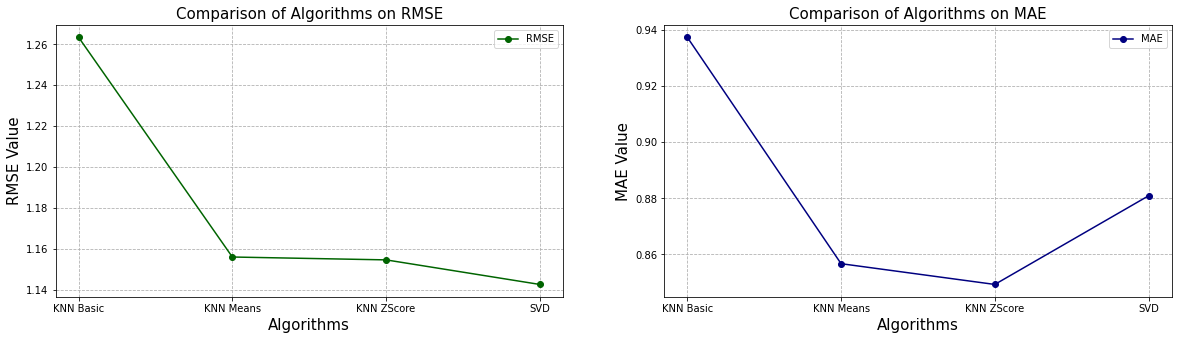

In [ ]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()


# **Using GridserachSV to get best parameter for SVD**

In [ ]:
# Parameter space
svd_param_grid = {'n_epochs': [1, 5], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}


svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)


# **Best parameters for SVD**

In [ ]:
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

RMSE = {'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.4}
MAE = {'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.4}


In [ ]:
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))

SVD   - RMSE: 1.0614 ; MAE: 0.8046


# **Change parameters on KNN using GridSearchCV**

In [ ]:
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnbasic_gs.fit(data)

In [ ]:
knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs.fit(data)

In [ ]:
knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs.fit(data)

In [ ]:
x = [15, 20, 25, 30, 40, 50, 60]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

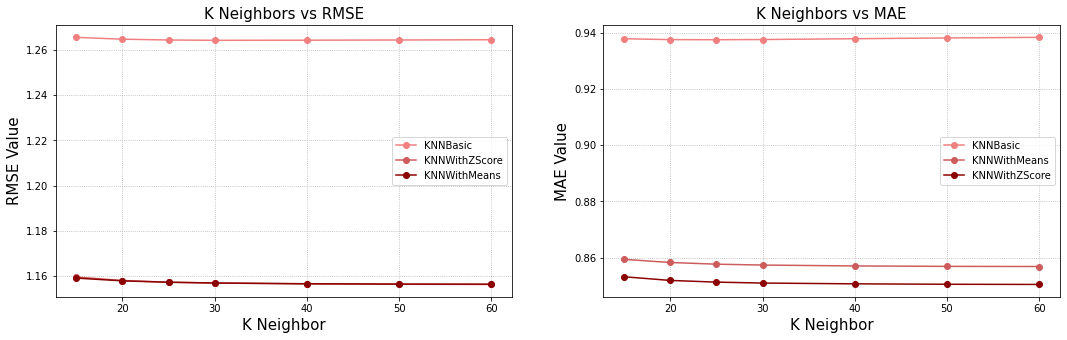

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()